# Import libraries

In [1]:
from pyomo.opt import SolverStatus, TerminationCondition
import pyomo.environ as pyo

import pandas as pd
import time
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams["font.size"] = 8

# Read data

In [2]:
address = "Deterministic_1.xlsx"
Data = pd.read_excel(address, sheet_name='hourly', index_col= 0)
ECUData = pd.read_excel(address, sheet_name='ECU', index_col= 0)

# define parameters

In [3]:
############ CRF
i = 0.1
n = 20
CRF = ( i*(i+1)**n ) / ( (1+i)**n - 1 )

############ NG price
NGprice = 0.05 # $/m3

############ NG LHV
LHV = 9.7 # kWh/m3

############ set of time steps
T = list(Data.index)

############ set of ECUs
ECU = ['T', 'B', 'CHP', 'EC', 'WC', 'PV', 'SWH']

############ set of days
D = ['warm', 'cold']

############ weight of days
w = {'warm': 0.6, 'cold': 0.4}

# define the model and decision variables

In [4]:
model = pyo.ConcreteModel(name="Deterministic_1")

def capacity_upper_bounds(model,ecu):
    return (0, ECUData.loc[ecu,'CapMax'])
model.cap = pyo.Var(list(set(ECU)-{'PV', 'SWH'}), within=pyo.NonNegativeReals, bounds=capacity_upper_bounds)

model.Bin = pyo.Var(list(set(ECU)-{'T', 'B', 'CHP', 'EC', 'WC'}), within=pyo.Binary)

model.IC = pyo.Var(within=pyo.NonNegativeReals)
model.OC = pyo.Var(within=pyo.NonNegativeReals)

model.EleGrid = pyo.Var(T,D, within=pyo.NonNegativeReals)
model.NGGrid  = pyo.Var(T,D, within=pyo.NonNegativeReals)

model.NGCHP = pyo.Var(T,D, within=pyo.NonNegativeReals)
model.NGB = pyo.Var(T,D, within=pyo.NonNegativeReals)

model.E = pyo.Var(T,D,list(set(ECU)-{'B', 'SWH'}), within=pyo.NonNegativeReals)
model.H = pyo.Var(T,D,list(set(ECU)-{'T','EC', 'WC', 'PV'}), within=pyo.NonNegativeReals)
model.C = pyo.Var(T,D,list(set(ECU)-{'T', 'B', 'CHP','PV', 'SWH'}), within=pyo.NonNegativeReals)

# objective function

In [5]:
def initial_cost_rule(model):
    return model.IC == sum( model.cap[ecu]*ECUData.loc[ecu,'IC'] for ecu in list(set(ECU)-{'PV', 'SWH'}))+\
           sum( model.Bin[ecu]*ECUData.loc[ecu,'IC'] for ecu in list(set(ECU)-{'T', 'B', 'CHP', 'EC', 'WC'}))
model.initial_cost = pyo.Constraint(rule= initial_cost_rule)

def operation_cost_rule(model):
    return model.OC == sum( w[d]*365*(model.EleGrid[t,d]*Data.loc[t,'electricity price'] + model.NGGrid[t,d]*NGprice)\
                            for t in T for d in D )
model.operation_cost = pyo.Constraint(rule= operation_cost_rule)

def obj_rule(model):    
    return CRF*model.IC + model.OC
model.obj = pyo.Objective(rule=obj_rule, sense = pyo.minimize)

# balances

In [6]:
####################################### electricity balance

def electricity_balance_rule(model,t,d):
    if d == 'warm':
        return model.E[t,d,'T']+model.E[t,d,'CHP']+model.E[t,d,'PV']-model.E[t,d,'EC']-model.E[t,d,'WC']\
        == Data.loc[t,'electricity (Summer)']
    else:
        return model.E[t,d,'T']+model.E[t,d,'CHP']+model.E[t,d,'PV']-model.E[t,d,'EC']-model.E[t,d,'WC']\
        == Data.loc[t,'electricity (Winter)']
model.electricity_balance = pyo.Constraint(T,D,rule= electricity_balance_rule)

####################################### heating balance

def heating_balance_rule(model,t,d):
    if d == 'warm':
        return model.H[t,d,'B']+model.H[t,d,'SWH']+model.H[t,d,'CHP'] == Data.loc[t,'heat (Summer)']
    else:
        return model.H[t,d,'B']+model.H[t,d,'SWH']+model.H[t,d,'CHP'] == Data.loc[t,'heat (Winter)']
model.heating_balance = pyo.Constraint(T,D,rule= heating_balance_rule)

####################################### cooling balance

def cooling_balance_rule(model,t,d):
    if d == 'warm':
        return model.C[t,d,'EC']+model.C[t,d,'WC'] == Data.loc[t,'cooling (Summer)']
    else:
        return model.C[t,d,'EC']+model.C[t,d,'WC'] == Data.loc[t,'cooling (Winter)']
model.cooling_balance = pyo.Constraint(T,D,rule= cooling_balance_rule)

####################################### NG balance

def NG_balance_rule(model,t,d):
    return model.NGCHP[t,d] + model.NGB[t,d] == model.NGGrid[t,d]
model.NG_balance_rule = pyo.Constraint(T,D,rule= NG_balance_rule)

# ECU models

In [7]:
####################################### transformer

def transformer_rule(model,t,d):
    return model.E[t,d,'T'] == ECUData.loc['T','Param1']*model.EleGrid[t,d]
model.transformer = pyo.Constraint(T,D,rule= transformer_rule)

def trans_cap_rule(model,t,d):
    return model.E[t,d,'T'] <= model.cap['T']
model.trans_cap = pyo.Constraint(T,D,rule= trans_cap_rule)

####################################### CHP

def CHP_cap_rule(model,t,d):
    return model.E[t,d,'CHP'] <= model.cap['CHP']
model.CHP_cap = pyo.Constraint(T,D,rule= CHP_cap_rule)

######## Electricity

def CHP_electricity_rule(model,t,d):
    return model.E[t,d,'CHP'] == ECUData.loc['CHP','Param1']*model.NGCHP[t,d]*LHV
model.CHP_electricity = pyo.Constraint(T,D,rule= CHP_electricity_rule)

######## heat

def CHP_heating_rule(model,t,d):
    return model.H[t,d,'CHP'] == ECUData.loc['CHP','Param2']*model.NGCHP[t,d]*LHV
model.CHP_heating = pyo.Constraint(T,D,rule= CHP_heating_rule)

####################################### Electric chiller

def electric_chiller_rule(model,t,d):
    return model.C[t,d,'EC'] == ECUData.loc['EC','Param1']*model.E[t,d,'EC']
model.electric_chiller = pyo.Constraint(T,D,rule= electric_chiller_rule)

def EC_cap_rule(model,t,d):
    return model.C[t,d,'EC'] <= model.cap['EC']
model.EC_cap = pyo.Constraint(T,D,rule= EC_cap_rule)

####################################### water chiller

def water_chiller_rule(model,t,d):
    return model.C[t,d,'WC'] == ECUData.loc['WC','Param1']*model.E[t,d,'WC']
model.water_chiller = pyo.Constraint(T,D,rule= water_chiller_rule)

def WC_cap_rule(model,t,d):
    return model.C[t,d,'WC'] <= model.cap['WC']
model.WC_cap = pyo.Constraint(T,D,rule= WC_cap_rule)

####################################### boiler

def boiler_heating_rule(model,t,d):
    return model.H[t,d,'B'] == ECUData.loc['B','Param1']*model.NGB[t,d]*LHV
model.boiler_heating = pyo.Constraint(T,D,rule= boiler_heating_rule)

def boiler_cap_rule(model,t,d):
    return model.H[t,d,'B'] <= model.cap['B']
model.boiler_cap = pyo.Constraint(T,D,rule= boiler_cap_rule)

####################################### PV

def PV_existance_rule(model,t,d):
    return model.E[t,d,'PV'] <= model.Bin['PV']
model.PV_existance = pyo.Constraint(T,D,rule= PV_existance_rule)

####################################### SWH

def SWH_existance_rule(model,t,d):
    return model.H[t,d,'SWH'] <= model.Bin['SWH']
model.SWH_existance = pyo.Constraint(T,D,rule= SWH_existance_rule)


# solve the model

In [8]:
start_time = time.time()
results = pyo.SolverFactory('glpk').solve(model)
end_time = time.time()

solver_status = results.solver.status
termination_condition = results.solver.termination_condition
run_time = end_time - start_time
if (solver_status == SolverStatus.ok) and (termination_condition == TerminationCondition.optimal):
    print(f"Solver Status: OK")
    print("Termination Condition: Optimal")
    print(f"run time (s): {run_time}")
    pyo.assert_optimal_termination(results)
else:
    print("Global optimal solution was not found.")
    print(f"Solver Status: {solver_status}")
    print(f"Termination Condition: {termination_condition}")

Solver Status: OK
Termination Condition: Optimal
run time (s): 0.14382052421569824


In [10]:
print(f'Objective value = {pyo.value(model.obj)}')
print(f'operation cost ($/year) = {model.OC.value}')
print(f'initial cost ($) = {model.IC.value}')

for ecu in ECU:
    if ecu != 'PV' and ecu != 'SWH':
        temp = model.cap[ecu].value
        print(f'{ecu} capacity (kW)= {temp}')
    else:
        temp = model.Bin[ecu].value
        print(f'{ecu} = {temp}')

Objective value = 1064.6643990024359
operation cost ($/year) = 872.089344187847
initial cost ($) = 1639.5
T capacity (kW)= 1.775
B capacity (kW)= 1.6
CHP capacity (kW)= 0.6
EC capacity (kW)= 4.0
WC capacity (kW)= 0.0
PV = 1.0
SWH = 0.0


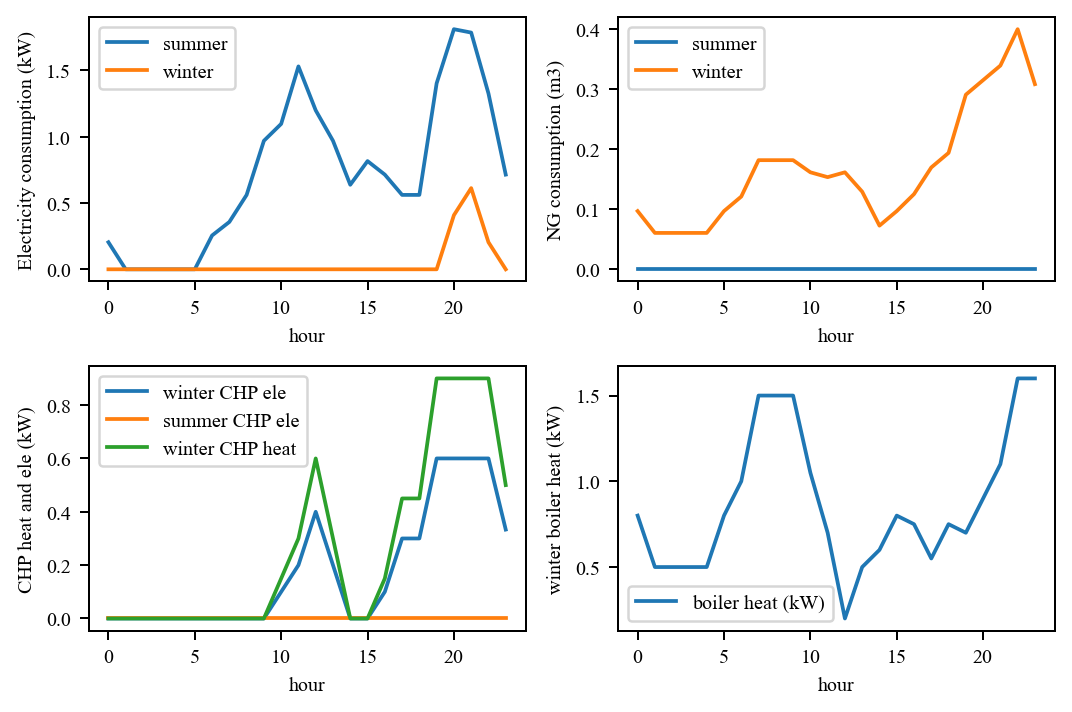

In [30]:
Egrid_summer = [model.EleGrid[t,'warm'].value for t in T]
Egrid_winter = [model.EleGrid[t,'cold'].value for t in T]

plt.figure(dpi=180, figsize=(6,4))
plt.subplot(2,2,1)
plt.plot(Egrid_summer)
plt.plot(Egrid_winter)
plt.legend(['summer','winter'])
plt.xlabel('hour')
plt.ylabel('Electricity consumption (kW)')

#########################################################

NGgrid_summer = [model.NGGrid[t,'warm'].value for t in T]
NGgrid_winter = [model.NGGrid[t,'cold'].value for t in T]

plt.subplot(2,2,2)
plt.plot(NGgrid_summer)
plt.plot(NGgrid_winter)
plt.legend(['summer','winter'])
plt.xlabel('hour')
plt.ylabel('NG consumption (m3)')

#########################################################

EleCHPC = [model.E[t,'cold','CHP'].value for t in T]
EleCHPH = [model.E[t,'warm','CHP'].value for t in T]
HCHP = [model.H[t,'cold','CHP'].value for t in T]

plt.subplot(2,2,3)
plt.plot(EleCHPC)
plt.plot(EleCHPH)
plt.plot(HCHP)
plt.legend(['winter CHP ele', 'summer CHP ele', 'winter CHP heat'])
plt.xlabel('hour')
plt.ylabel('CHP heat and ele (kW)')

#########################################################

Hboiler = [model.H[t,'cold','B'].value for t in T]

plt.subplot(2,2,4)
plt.plot(Hboiler)
plt.legend(['boiler heat (kW)'])
plt.xlabel('hour')
plt.ylabel('winter boiler heat (kW)')

plt.tight_layout()